<a href="https://colab.research.google.com/github/dinesh-saka/Stock-Pattern-Prediction-Using-LSTM/blob/main/StockPatternPredictionUsingLSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [24]:
!pip install tensorflow -qqq
!pip install keras -qqq
!pip install yfinance -qqq

In [25]:
import tensorflow as tf
import keras
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Check TensorFlow version
print("TensorFlow Version: ", tf.__version__)

TensorFlow Version:  2.15.0


In [26]:
# Fetch AAPL data
aapl_data = yf.download('AAPL', start='2019-01-01', end='2024-01-01')

# Display the first few rows of the dataframe
aapl_data.head()

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-01-02,38.722500,39.712502,38.557499,39.480000,37.793781,148158800
2019-01-03,35.994999,36.430000,35.500000,35.547501,34.029243,365248800
2019-01-04,36.132500,37.137501,35.950001,37.064999,35.481930,234428400
2019-01-07,37.174999,37.207500,36.474998,36.982498,35.402946,219111200
2019-01-08,37.389999,37.955002,37.130001,37.687500,36.077843,164101200


In [27]:
# Checking for missing values
aapl_data.isnull().sum()

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [28]:
# # Filling missing values, if any
# aapl_data.fillna(method='ffill', inplace=True)

For our model, we’ll use ‘Close’ prices, but you can experiment with additional features like ‘Open’, ‘High’, ‘Low’, and ‘Volume’.

In [29]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0,1))
aapl_data_scaled = scaler.fit_transform(aapl_data['Close'].values.reshape(-1,1))

In [30]:
aapl_data_scaled

array([[0.02419069],
       [0.        ],
       [0.00933486],
       ...,
       [0.96948862],
       [0.9721338 ],
       [0.96567473]])

Defining Sequence Length: Choose a sequence length (like 60 days). This means, for every sample, the model will look at the last 60 days of data to make a prediction.

In [31]:
X = []
y = []

for i in range(60, len(aapl_data_scaled)):
    X.append(aapl_data_scaled[i-60:i, 0])
    y.append(aapl_data_scaled[i, 0])

### Train-Test Split

In [32]:
train_size = int(len(X) * 0.8)
test_size = len(X) - train_size

X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

Finally, we need to reshape our data into a 3D format [samples, time steps, features] required by LSTM layers.

In [33]:
X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

##Building the LSTM with Attention Model

In [34]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, AdditiveAttention, Permute, Reshape, Multiply

model = Sequential()

# Adding LSTM layers with return_sequences=True
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(units=50, return_sequences=True))

### Adding attention mechanism

* First Permute: Swaps dimensions to make the tensor compatible for attention mechanism.

* Reshape: Flattens dimensions for attention mechanism.
Attention Mechanism: Computes attention weights.

* Multiply: Applies the attention weights.

* Second Permute: Reverts the dimensions to the original order.

* Final Reshape: Returns to the original shape.

In [35]:
# The attention mechanism
attention = AdditiveAttention(name='attention_weight')
# Permute and reshape for compatibility
model.add(Permute((2, 1)))
model.add(Reshape((-1, X_train.shape[1])))
attention_result = attention([model.output, model.output])
multiply_layer = Multiply()([model.output, attention_result])
# Return to original shape
model.add(Permute((2, 1)))
model.add(Reshape((-1, 50)))

# Adding a Flatten layer before the final Dense layer
model.add(tf.keras.layers.Flatten())

# Final Dense layer
model.add(Dense(1))

###Optimizing the Model

In [36]:
from keras.layers import BatchNormalization

# Adding Dropout and Batch Normalization
model.add(Dropout(0.2))
model.add(BatchNormalization())

* Dropout: Helps prevent overfitting by randomly deactivating a fraction of neurons during training.
* Batch Normalization: Stabilizes and accelerates training by normalizing activations, allowing higher learning rates and making the network less sensitive to initialization.

##Model Compilation

In [37]:
model.compile(optimizer='adam', loss='mean_squared_error')

In [38]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 60, 50)            10400     
                                                                 
 lstm_3 (LSTM)               (None, 60, 50)            20200     
                                                                 
 permute_3 (Permute)         (None, 50, 60)            0         
                                                                 
 reshape_2 (Reshape)         (None, 50, 60)            0         
                                                                 
 permute_4 (Permute)         (None, 60, 50)            0         
                                                                 
 reshape_3 (Reshape)         (None, 60, 50)            0         
                                                                 
 flatten_1 (Flatten)         (None, 3000)             

### Training

In [39]:
history = model.fit(X_train, y_train, epochs=100, batch_size=25, validation_split=0.2)

Epoch 1/100
31/31 [==============================] - 5s 35ms/step - loss: 0.9998 - val_loss: 0.4767
Epoch 2/100
31/31 [==============================] - 0s 10ms/step - loss: 0.2035 - val_loss: 0.3707
Epoch 3/100
31/31 [==============================] - 0s 12ms/step - loss: 0.1494 - val_loss: 0.3464
Epoch 4/100
31/31 [==============================] - 0s 10ms/step - loss: 0.1325 - val_loss: 0.3113
Epoch 5/100
31/31 [==============================] - 0s 10ms/step - loss: 0.1130 - val_loss: 0.2821
Epoch 6/100
31/31 [==============================] - 0s 11ms/step - loss: 0.0983 - val_loss: 0.2522
Epoch 7/100
31/31 [==============================] - 0s 16ms/step - loss: 0.0862 - val_loss: 0.2272
Epoch 8/100
31/31 [==============================] - 0s 16ms/step - loss: 0.0726 - val_loss: 0.2104
Epoch 9/100
31/31 [==============================] - 1s 16ms/step - loss: 0.0636 - val_loss: 0.1875
Epoch 10/100
31/31 [==============================] - 1s 17ms/step - loss: 0.0528 - val_loss: 0.1696

###Early Stopping

Early Stopping: This technique stops training when the model’s performance on the validation set starts to degrade.

In [40]:
from keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=10)
history = model.fit(X_train, y_train, epochs=100, batch_size=25, validation_split=0.2, callbacks=[early_stopping])

Epoch 1/100
31/31 [==============================] - 1s 27ms/step - loss: 0.0171 - val_loss: 0.0083
Epoch 2/100
31/31 [==============================] - 1s 22ms/step - loss: 0.0166 - val_loss: 0.0010
Epoch 3/100
31/31 [==============================] - 0s 12ms/step - loss: 0.0154 - val_loss: 0.0050
Epoch 4/100
31/31 [==============================] - 0s 12ms/step - loss: 0.0176 - val_loss: 0.0034
Epoch 5/100
31/31 [==============================] - 0s 14ms/step - loss: 0.0169 - val_loss: 0.0375
Epoch 6/100
31/31 [==============================] - 0s 14ms/step - loss: 0.0156 - val_loss: 9.7343e-04
Epoch 7/100
31/31 [==============================] - 0s 15ms/step - loss: 0.0164 - val_loss: 0.0033
Epoch 8/100
31/31 [==============================] - 1s 19ms/step - loss: 0.0158 - val_loss: 0.0016
Epoch 9/100
31/31 [==============================] - 1s 20ms/step - loss: 0.0167 - val_loss: 0.0011
Epoch 10/100
31/31 [==============================] - 0s 15ms/step - loss: 0.0159 - val_loss: 0.

Here, patience=10 means training will stop if the validation loss does not improve for 10 consecutive epochs

## Callbacks

In [41]:
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, TensorBoard, CSVLogger

# Callback to save the model periodically
model_checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_loss')

# Callback to reduce learning rate when a metric has stopped improving
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5)

# Callback for TensorBoard
tensorboard = TensorBoard(log_dir='./logs')

# Callback to log details to a CSV file
csv_logger = CSVLogger('training_log.csv')

# Combining all callbacks
callbacks_list = [early_stopping, model_checkpoint, reduce_lr, tensorboard, csv_logger]

# Fit the model with the callbacks
history = model.fit(X_train, y_train, epochs=100, batch_size=25, validation_split=0.2, callbacks=callbacks_list)

Epoch 1/100
31/31 [==============================] - 1s 25ms/step - loss: 0.0149 - val_loss: 0.0036 - lr: 0.0010
Epoch 2/100
 4/31 [==>...........................] - ETA: 0s - loss: 0.0122

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


31/31 [==============================] - 1s 16ms/step - loss: 0.0153 - val_loss: 0.0015 - lr: 0.0010
Epoch 3/100
31/31 [==============================] - 0s 12ms/step - loss: 0.0188 - val_loss: 0.0212 - lr: 0.0010
Epoch 4/100
31/31 [==============================] - 0s 12ms/step - loss: 0.0179 - val_loss: 0.0018 - lr: 0.0010
Epoch 5/100
31/31 [==============================] - 0s 12ms/step - loss: 0.0142 - val_loss: 9.5891e-04 - lr: 0.0010
Epoch 6/100
31/31 [==============================] - 0s 11ms/step - loss: 0.0152 - val_loss: 0.0068 - lr: 0.0010
Epoch 7/100
31/31 [==============================] - 0s 12ms/step - loss: 0.0176 - val_loss: 0.0150 - lr: 0.0010
Epoch 8/100
31/31 [==============================] - 0s 10ms/step - loss: 0.0181 - val_loss: 0.0010 - lr: 0.0010
Epoch 9/100
31/31 [==============================] - 0s 10ms/step - loss: 0.0156 - val_loss: 0.0069 - lr: 0.0010
Epoch 10/100
31/31 [==============================] - 0s 12ms/step - loss: 0.0158 - val_loss: 0.0015 - l

## Evaluating Model Performance

In [42]:
# Convert X_test and y_test to Numpy arrays if they are not already
X_test = np.array(X_test)
y_test = np.array(y_test)

# Ensure X_test is reshaped similarly to how X_train was reshaped
# This depends on how you preprocessed the training data
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Now evaluate the model on the test data
test_loss = model.evaluate(X_test, y_test)
print("Test Loss: ", test_loss)

8/8 [==============================] - 0s 6ms/step - loss: 0.0063
Test Loss:  0.006251739803701639


In [43]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Making predictions
y_pred = model.predict(X_test)

# Calculating MAE and RMSE
mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)

print("Mean Absolute Error: ", mae)
print("Root Mean Square Error: ", rmse)

8/8 [==============================] - 1s 5ms/step
Mean Absolute Error:  0.07423712756934957
Root Mean Square Error:  0.07906794726259682


## Making Predictions

In [46]:
import yfinance as yf
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Fetching the latest 3 months of AAPL stock data
data = yf.download('AAPL', period='3mo', interval='1d')

# Check if the data was fetched successfully
if data.empty:
    raise ValueError("Failed to fetch data. Please check the ticker or network connection.")

# Ensure we have at least 60 days of data
if len(data) < 60:
    raise ValueError("Not enough data to fetch 60 days of closing prices.")

# Selecting the 'Close' price and converting to numpy array
closing_prices = data['Close'].values[-60:]  # Select only the last 60 days

# Scaling the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(closing_prices.reshape(-1, 1))

# Preparing the data for the model
X_latest = np.array([scaled_data.reshape(60, 1)])

# Making predictions for the next 4 candles
predicted_stock_price = model.predict(X_latest)
predicted_stock_price = scaler.inverse_transform(predicted_stock_price)

print("Predicted Stock Prices for the next 4 days: ", predicted_stock_price)


[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 117ms/step
Predicted Stock Prices for the next 4 days:  [[187.50714]]


In [47]:
import yfinance as yf
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Fetch the latest 60 days of AAPL stock data
data = yf.download('AAPL', period='3mo', interval='1d')

# Select 'Close' price and scale it
closing_prices = data['Close'].values.reshape(-1, 1)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(closing_prices)

# Predict the next 4 days iteratively
predicted_prices = []
current_batch = scaled_data[-60:].reshape(1, 60, 1)  # Most recent 60 days

for i in range(4):  # Predicting 4 days
    # Get the prediction (next day)
    next_prediction = model.predict(current_batch)

    # Reshape the prediction to fit the batch dimension
    next_prediction_reshaped = next_prediction.reshape(1, 1, 1)

    # Append the prediction to the batch used for predicting
    current_batch = np.append(current_batch[:, 1:, :], next_prediction_reshaped, axis=1)

    # Inverse transform the prediction to the original price scale
    predicted_prices.append(scaler.inverse_transform(next_prediction)[0, 0])

print("Predicted Stock Prices for the next 4 days: ", predicted_prices)

[*********************100%%**********************]  1 of 1 completed

1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 28ms/step
Predicted Stock Prices for the next 4 days:  [187.50714, 186.86244, 186.23384, 185.82748]


## Visualization

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.0/75.0 kB 2.2 MB/s eta 0:00:00


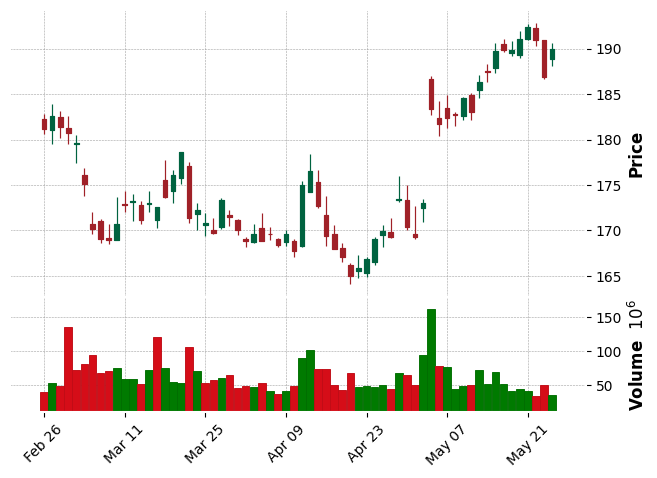

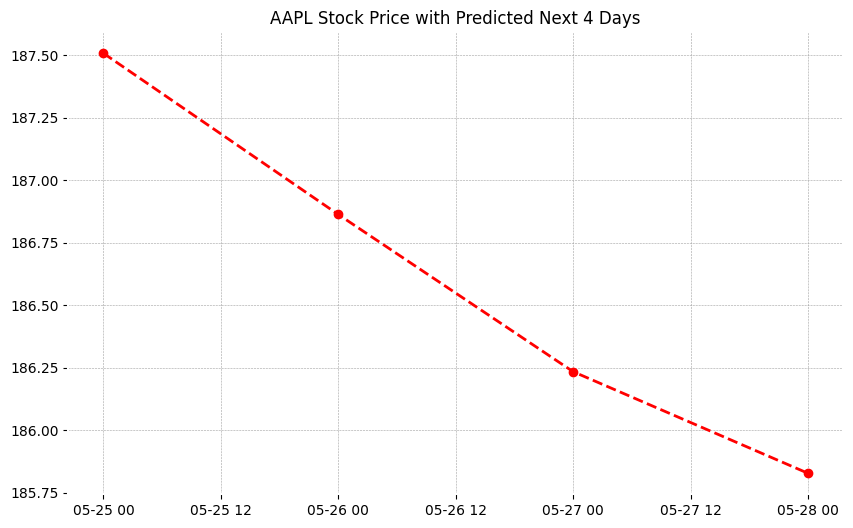

In [48]:
!pip install mplfinance -qqq
import pandas as pd
import mplfinance as mpf
import matplotlib.dates as mpl_dates
import matplotlib.pyplot as plt

# Assuming 'data' is your DataFrame with the fetched AAPL stock data
# Make sure it contains Open, High, Low, Close, and Volume columns

# Creating a list of dates for the predictions
last_date = data.index[-1]
next_day = last_date + pd.Timedelta(days=1)
prediction_dates = pd.date_range(start=next_day, periods=4)

# Assuming 'predicted_prices' is your list of predicted prices for the next 4 days
predictions_df = pd.DataFrame(index=prediction_dates, data=predicted_prices, columns=['Close'])

# Plotting the actual data with mplfinance
mpf.plot(data, type='candle', style='charles', volume=True)

# Overlaying the predicted data
plt.figure(figsize=(10,6))
plt.plot(predictions_df.index, predictions_df['Close'], linestyle='dashed', marker='o', color='red')

plt.title("AAPL Stock Price with Predicted Next 4 Days")
plt.show()

[*********************100%%**********************]  1 of 1 completed


1/1 [==============================] - 0s 47ms/step


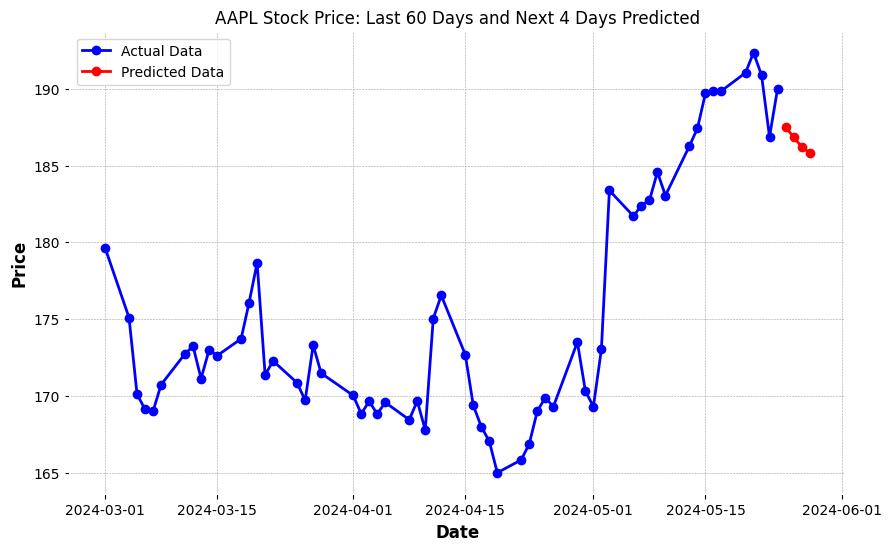

In [50]:
import pandas as pd
import mplfinance as mpf
import matplotlib.dates as mpl_dates
import matplotlib.pyplot as plt

# Fetch the latest 60 days of AAPL stock data
data = yf.download('AAPL', period='3mo', interval='1d') # Fetch 64 days to display last 60 days in the chart

# Select 'Close' price and scale it
closing_prices = data['Close'].values.reshape(-1, 1)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(closing_prices)

# Predict the next 4 days iteratively
predicted_prices = []
current_batch = scaled_data[-60:].reshape(1, 60, 1)  # Most recent 60 days

for i in range(4):  # Predicting 4 days
    next_prediction = model.predict(current_batch)
    next_prediction_reshaped = next_prediction.reshape(1, 1, 1)
    current_batch = np.append(current_batch[:, 1:, :], next_prediction_reshaped, axis=1)
    predicted_prices.append(scaler.inverse_transform(next_prediction)[0, 0])

# Creating a list of dates for the predictions
last_date = data.index[-1]
next_day = last_date + pd.Timedelta(days=1)
prediction_dates = pd.date_range(start=next_day, periods=4)

# Adding predictions to the DataFrame
predicted_data = pd.DataFrame(index=prediction_dates, data=predicted_prices, columns=['Close'])

# Combining both actual and predicted data
combined_data = pd.concat([data['Close'], predicted_data['Close']])
combined_data = combined_data[-64:] # Last 60 days of actual data + 4 days of predictions

# Plotting the actual data
plt.figure(figsize=(10,6))
plt.plot(data.index[-60:], data['Close'][-60:], linestyle='-', marker='o', color='blue', label='Actual Data')

# Plotting the predicted data
plt.plot(prediction_dates, predicted_prices, linestyle='-', marker='o', color='red', label='Predicted Data')

plt.title("AAPL Stock Price: Last 60 Days and Next 4 Days Predicted")
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()